# 건축 데이터 전처리 + 시각화
: 최근 수집된 건축 관련 원시 데이터 

출처

- 건축데이터 민간개방 시스템 https://open.eais.go.kr/main/main.do

처리 목적 
- 건축인허가 데이터를 바탕으로 주택유형을 분류하고 주택인허가 데이터를 통해 건축 승인일을 확인하여 영남지방의 도시형생활주택을 확인 

처리사항

    - 건축 데이터와 주택 유형 데이터를 합산하여 도시형 생활주택과 준주택을 구별하여 추출
    
    - 세분화된 도시형생활주택을 하나의 도시형생활주택으로 합산 
    
    - 각 지역별 주택용도를 구분하여 파이챠트로 시각화 
    
    - 각 지역별 주택용도를 연도에 따라 막대 그래프로 시각화 
    
    - 각 지역별 2017년 이전 건축된 도시형생활주택을 단계구분도로 시각화
    



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [33]:
# 모듈 호출
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [4]:
# 한글 폰트 지원
import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

Unknown system...  sorry~~~


In [5]:
# 두 데이터셋에서 필요한 컬럼만을 추출한 후 하나의 데이터로 합치는 사용자 함수 생성
def func1(region):
    df1=pd.read_excel('/content/drive/MyDrive/아/코드 파일/지역별 건축인허가(기본)/'+region+'.xlsx',header = 4,usecols=['대지위치','시군구코드','법정동코드','관리허가대장관리번호','건축허가일','생성일자'])
    print(df1.shape)
    df2=pd.read_excel('/content/drive/MyDrive/아/코드 파일/지역별 건축인허가(주택용도)/'+region+'.xlsx',header = 4,usecols=['대지위치','시군구코드','법정동코드','번','지','관리허가대장관리번호','주택유형구분명','생성일자'])
    print(df2.shape)
    df = df1.merge(df2)
    df = df.astype('str')
    df['허가년도'] = df.건축허가일.str[:4]
    df['허가년월'] = df.건축허가일.str[:6]
 
    df = df.astype({'허가년월':'int'})
    df['행정동'] = df.대지위치.str.split().str[0] + ' ' + df.대지위치.str.split().str[1] + ' '+df.대지위치.str.split().str[2]
    df['통합코드'] = df.시군구코드 +  df.법정동코드.str[:3]
    df = df.drop_duplicates()
    df.drop(df[df['주택유형구분명'] == 'nan'].index, inplace=True)
    df.loc[df['주택유형구분명'] == '도시형생활주택(단지형연립주택)','주택유형구분명' ]= '도시형생활주택'
    df.loc[df['주택유형구분명'] == '도시형생활주택(원룸형주택)','주택유형구분명' ]= '도시형생활주택'
    df.loc[df['주택유형구분명'] == '도시형생활주택(단지형다세대주택)','주택유형구분명' ]= '도시형생활주택'
    df.loc[df['주택유형구분명'] == '준주택(오피스텔)','주택유형구분명' ]= '오피스텔'
    df.loc[df['주택유형구분명'] == '준주택(고시원)','주택유형구분명' ]= '고시원'
    df.loc[df['주택유형구분명'] == '준주택(기숙사)','주택유형구분명' ]= '기숙사'
    df.loc[df['주택유형구분명'] == '준주택(노인복지주택)','주택유형구분명' ]= '노인복지주택'
    return df


# 2017년 이전 건축된 도시형 생활주택 찾는 함수 생성
def func2(df):
    return df[(df['허가년월']<=201701) & (df['주택유형구분명'].str.contains('도시형생활주택'))]


In [6]:
# 각 시별 전체 주택용도 
gyeongju = func1('경주시')
gimhae = func1('김해시')
miryang = func1('밀양시')
busan = pd.concat([func1('부산 강서구'),func1('부산 금정구'),func1('부산 기장군'),func1('부산 남구'),func1('부산 동구'),
                  func1('부산 동래구'),func1('부산 부산진구'),func1('부산 북구'),func1('부산 사상구'),
                  func1('부산 사하구'),func1('부산 서구'),func1('부산 수영구'),func1('부산 연제구'),
                  func1('부산 영도구'),func1('부산 중구'),func1('부산 해운대구')])
yangsan = func1('양산시')
yeongdeok = func1('영덕군')
ulsan = pd.concat([func1('울산 남구'),func1('울산 동구'),func1('울산 북구'),func1('울산 울주군'),func1('울산 중구')])
changwon = pd.concat([func1('창원시 마산합포구'),func1('창원시 마산회원구'),func1('창원시 성산구'),func1('창원시 의창구'),func1('창원시 진해구')])
pohang = pd.concat([func1('포항시 남구'),func1('포항시 북구')])

/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(40000, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(255, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(40000, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(255, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(27790, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(399, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(21829, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(97, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(15234, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(2473, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(21249, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(751, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(9065, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(3073, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(5878, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(706, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(22030, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(2878, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(21839, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(4595, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(7067, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(932, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(13083, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1941, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(16892, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1540, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(7010, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1476, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(9887, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(3689, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(10283, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(2377, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(5804, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(505, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(3829, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1045, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(14445, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(1021, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(31406, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(345, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(12404, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(47, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(40000, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(917, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(11608, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(138, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(19167, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(221, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(40000, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(349, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(21486, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(284, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(14033, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(129, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(9809, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(53, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(13932, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(12, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(19235, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(97, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(10809, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(66, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(37806, 6)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(116, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(26572, 6)
(138, 8)


/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# 각 시별 2017년 이전 필로티건물
gyeongju2 = func2(gyeongju)
gimhae2 = func2(gimhae)
miryang2 = func2(miryang)
busan2 = func2(busan)
yangsan2 = func2(yangsan)
yeongdeok2 = func2(yeongdeok)
ulsan2 = func2(ulsan)
changwon2 = func2(changwon)
pohang2 = func2(pohang)

In [8]:
total = pd.concat([gyeongju,gimhae,miryang,busan,yangsan,yeongdeok,ulsan,changwon,pohang])
total2 = pd.concat([gyeongju2,gimhae2,miryang2,busan2,yangsan2,yeongdeok2,ulsan2,changwon2,pohang2])


### 주택유형 구분 시각화

In [9]:
# 사용자 함수로 정의
def pie(df):
    plt.pie(df.주택유형구분명.value_counts(), # 비율 값
        autopct='%.1f%%', # 부채꼴 안에 표시될 숫자 형식(소수점 1자리까지 표시)
#         labels=total.주택유형구분명.value_counts().index
        ) 
    if '광역시' in df['행정동'].iloc[0].split(' ')[0]: 
        plt.title(df['행정동'].iloc[0].split(' ')[0]+' 도시형 생활주택 비율', fontsize=16)
    else:
        plt.title(df['행정동'].iloc[0].split(' ')[1]+' 도시형 생활주택 비율', fontsize=16)
#     plt.title('도시형 생활주택 비율', fontsize=16)
    plt.legend(df.주택유형구분명.value_counts().index, title='주택유형')
    plt.show()

#### 전체 기간의 주택 유형 구분 파이 챠트

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/

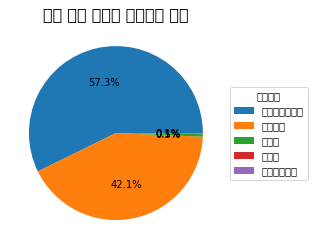

In [10]:
#전체 기간의 주택유형 구분 파이 차트 
plt.pie(total.주택유형구분명.value_counts(), # 비율 값
        autopct='%.1f%%', # 부채꼴 안에 표시될 숫자 형식(소수점 1자리까지 표시)
#         labels=total.주택유형구분명.value_counts().index
        ) 
plt.title('전체 기간 도시형 생활주택 비율', fontsize=16)
plt.legend(total.주택유형구분명.value_counts().index, title='주택유형',
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 경주시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPy

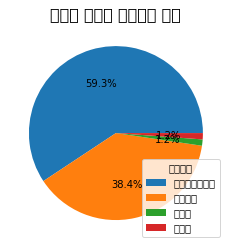

In [14]:
pie(gyeongju)

### 김해시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

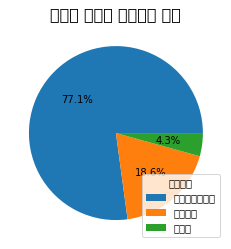

In [15]:
pie(gimhae)

### 밀양시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

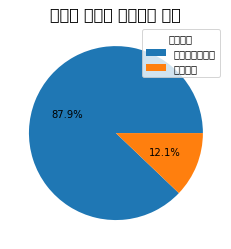

In [16]:
pie(miryang)

### 부산광역시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

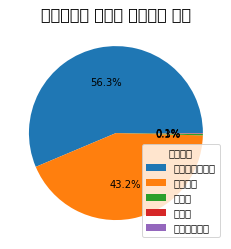

In [17]:
pie(busan)

### 양산시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyt

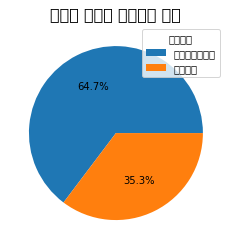

In [18]:
pie(yangsan)

### 영덕군 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 45909 (\N{HANGUL SYLLABLE DEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

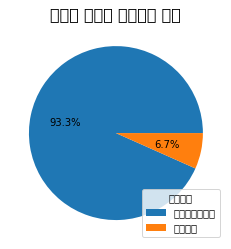

In [19]:
pie(yeongdeok)

### 울산광역시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

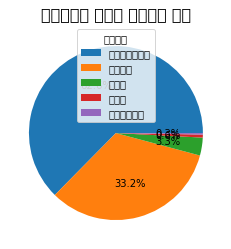

In [20]:
pie(ulsan)

### 창원시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPy

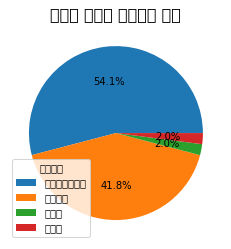

In [21]:
pie(changwon)

### 포항시 도시형 생활주택 비율

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

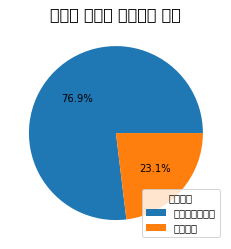

In [22]:
pie(pohang)

### 연도별 주택 유형 건축 인허가 그래프

### 경주시 그래프

In [23]:
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)

plt.title('경주시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

NameError: ignored

### 김해시 그래프 

In [ ]:
counts = gimhae.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('김해시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 부산광역시 그래프

In [ ]:
counts = busan.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.xticks(rotation=90)
plt.title('부산광역시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 양산시 그래프

In [ ]:
counts = yangsan.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('양산시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 영덕군 그래프

In [ ]:
counts = yeongdeok.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('영덕군')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 밀양시 그래프 

In [ ]:
counts = miryang.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('밀양시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 울산 광역시 그래프

In [ ]:
counts = ulsan.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('울산 광역시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 창원시 그래프

In [ ]:
counts = changwon.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('창원시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 포항시 그래프

In [ ]:
counts = pohang.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.title('포항시')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

In [ ]:
# 선정 지역 전체 그래프
df_list = [gyeongju ,gimhae,busan,yangsan,yeongdeok,ulsan,changwon,pohang]
df_all = pd.concat(df_list,ignore_index=True)
df_all

counts = df_all.groupby(['허가년도','주택유형구분명']).size().reset_index(name='count')
my_palette = sns.color_palette('husl',3)
sns.barplot(x='허가년도', 
            y='count', 
            hue='주택유형구분명',
            data=counts,
            palette= my_palette)
plt.xticks(rotation=90)
plt.title('선정지역 전체')
plt.legend(loc='upper right')
plt.figure(figsize=(10,4))
plt.show()

### 지진 피해 고위험 노출 지역 단계구분도 시각화

In [30]:
with open('/content/drive/MyDrive/아/코드 파일/geojson/busan.json',encoding='utf-8') as f:
    geo_busan = json.loads(f.read())

with open('/content/drive/MyDrive/아/코드 파일/geojson/ulsan.json',encoding='utf-8') as f:
    geo_ulsan = json.loads(f.read())
    
with open('/content/drive/MyDrive/아/코드 파일/geojson/경북최종.json',encoding='utf-8') as f:
    geo_gyeongbuk = json.loads(f.read())
    
with open('/content/drive/MyDrive/아/코드 파일/geojson/경남최종.json',encoding='utf-8') as f:
    geo_gyeongnam = json.loads(f.read())

In [31]:
df = total2.pivot_table(index='통합코드',columns='주택유형구분명',values='관리허가대장관리번호', aggfunc='count')
df


주택유형구분명,도시형생활주택
통합코드,
26110101,28
26110113,2
26110115,2
26110116,3
26110117,2
...,...
48330120,2
48330253,4
48330310,9


### 부산광역시 지진 피해 고위험 노출 지역 단계구분도 시각화

In [34]:
m = folium.Map(location=[35.1795543, 129.0756416],
              zoom_start=10)

folium.GeoJson(geo_busan).add_to(m)

folium.Choropleth(geo_data=geo_busan,
                  data=df['도시형생활주택'],
                  columns=[df.index, df['도시형생활주택']],
                  fill_color='YlGn', 
                  key_on='feature.properties.EMD_CD',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                 ).add_to(m)

m



### 울산광역시 지진 피해 고위험 노출 지역 단계구분도 시각화

In [35]:

m = folium.Map(location=[35.5383773,129.3113596],
              zoom_start=10)

folium.GeoJson(geo_ulsan).add_to(m)

folium.Choropleth(geo_data=geo_ulsan,
                  data=df['도시형생활주택'],
                  columns=[df.index, df['도시형생활주택']],
                  fill_color='YlGn', 
                  key_on='feature.properties.EMD_CD',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                 ).add_to(m)


m


### 경상남도 지진 피해 고위험 노출 지역 단계구분도 시각화

In [36]:
m = folium.Map(location=[	35.302605624625, 128.74634230328],
              zoom_start=10)

folium.GeoJson(geo_gyeongnam).add_to(m)

folium.Choropleth(geo_data=geo_gyeongnam,
                  data=df['도시형생활주택'],
                  columns=[df.index, df['도시형생활주택']],
                  fill_color='YlGn', 
                  key_on='feature.properties.EMD_CD',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                 ).add_to(m)


m


### 경상북도 지진 피해 고위험 노출 지역 단계구분도 시각화

In [40]:
### 경상북도 지진 피해 고위험 노출 지역 단계구분도 시각화
m = folium.Map(location=[	36.097135764145, 129.33724239195],
              zoom_start=10)

folium.GeoJson(geo_gyeongbuk).add_to(m)

folium.Choropleth(geo_data=geo_gyeongbuk,
                  data=df['도시형생활주택'],
                  columns=[df.index, df['도시형생활주택']],
                  fill_color='YlGn', 
                  key_on='feature.properties.EMD_CD',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                 ).add_to(m)


m

In [41]:
def draw_map(city):
    with open('/content/drive/MyDrive/아/코드 파일/geojson/'+city+'.json',encoding='utf-8') as f:
        geo_city = json.loads(f.read())
    
    m = folium.Map(location=[37.566535, 126.9779691999996],
              zoom_start=8)
    folium.GeoJson(geo_city).add_to(m)
    folium.Choropleth(geo_data=geo_city,
                  data=df['도시형생활주택'],
                  columns=[df.index, df['도시형생활주택']],
                  fill_color='YlGn', 
                  key_on='feature.properties.EMD_CD',
                  fill_opacity=0.7,
                  line_opacity=0.3,
                 ).add_to(m)
    return m

In [42]:
draw_map('busan')